In [1]:
# LSTM training
import torch
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import json
import joblib

In [3]:
# If using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Base Parameters
WINDOW = 30  # frames
STRIDE = 10   # next window step
K_CONSEC_FALL = 8  # consecutive frames to alert
K_CONSEC_ATT = 5
CONFIG = "lstm"
CONFIG_LABEL = f"{WINDOW}_s{STRIDE}_kf{K_CONSEC_FALL}_ka{K_CONSEC_ATT}"
# Parameters
NUM_CLASSES = 3
OUTPUT_BASE_PATH = "results/fall_detect_yolo11n_pose_balanced"
OUTPUT_DATASET_DIR = f"{OUTPUT_BASE_PATH}/windows_{CONFIG_LABEL}/"
OUTPUT_LSTM_MODEL_DIR = f"{OUTPUT_BASE_PATH}/lstm_model_w{CONFIG_LABEL}_{CONFIG}"
OUTPUT_LSTM_MODEL_FULL = "lstm_model_full.keras"
OUTPUT_LSTM_MODEL_BEST = "lstm_model_best.keras"
OUTPUT_LSTM_MODEL_HISTORY = "lstm_model_history.json"
LSTM_TRAIN_TEST_SPLIT = f"{OUTPUT_LSTM_MODEL_DIR}/train_test_split"
os.makedirs(LSTM_TRAIN_TEST_SPLIT, exist_ok=True)

In [7]:
# Check class balance in npy files

labels = np.array([
    int(f.replace('.npy', '').split('_')[-1])
    for root, _, files in sorted(os.walk(OUTPUT_DATASET_DIR))
    for f in files if f.endswith('.npy')
])

# Count the quantity per class
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# If it is very unbalanced, the ideal is to correct it with undersampling, oversampling or SMOTE (synthetic data)

{0: 6183, 1: 2136, 2: 883}


In [9]:
# Class balancing

X, y = [], []
for root, dirs, files in sorted(os.walk(OUTPUT_DATASET_DIR)):
    for file in sorted(files):
        if file.endswith('.npy'):
            parts = file.replace('.npy', '').split('_')
            label = int(parts[-1])
            data = np.load(os.path.join(root, file))
            if data.shape[0] == WINDOW:
                X.append(data)
                y.append(label)
                
# Balancing classes before one-hot encoding (to categorically)
# This avoids "guessing" values and already considers the actual distribution of the data.
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

print("Class dictionary:", class_weight_dict)

print(set(y))
X = np.array(X)
y = to_categorical(y, NUM_CLASSES) # one_hot encoding conversion

print("X shape:", X.shape) # quantity of windows, and each window format (30,64)
print("Data variance:", np.var(X)) # the lower the better
print("Calculated class weights:")
for classe, peso in class_weight_dict.items():
    print(f"Class {classe}: weight {peso:.4f}")

Class dictionary: {0: 0.49609143350045826, 1: 1.4360174781523096, 2: 3.473763684409211}
{0, 1, 2}
X shape: (9202, 30, 128)
Data variance: 0.15491788
Calculated class weights:
Class 0: weight 0.4961
Class 1: weight 1.4360
Class 2: weight 3.4738


--- Gráfico da Variância ANTES do Scaling ---


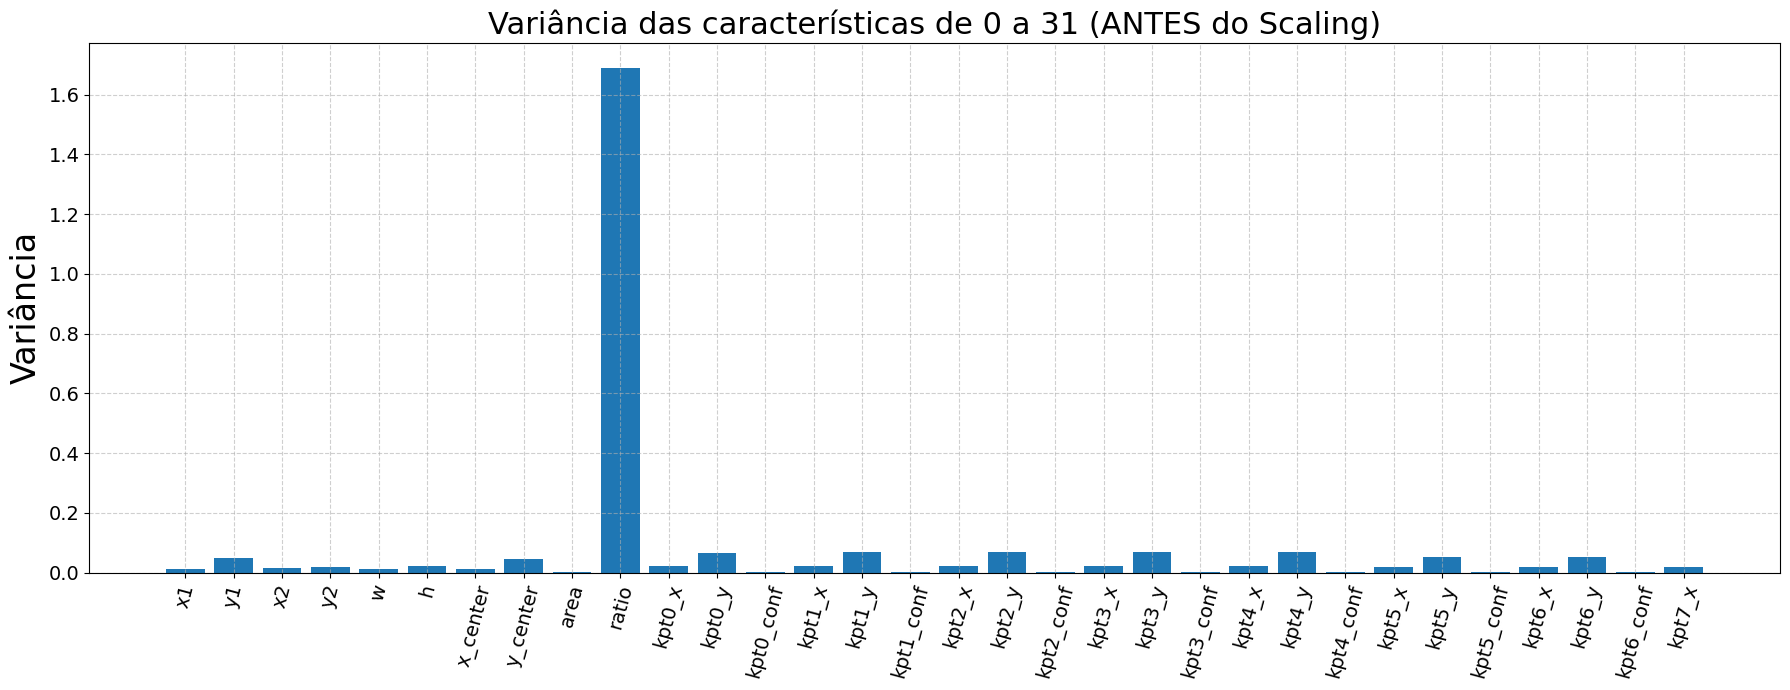

In [42]:
# X shape: (n_samples, n_frames, n_features) = (79740, 60, 64)
# 1️⃣ Achata as dimensões (samples, frames) e mantém só features
X_reshaped_before = X.reshape(-1, X.shape[2])  # O resultado será (9202 * 30, 128)

# 2️⃣ Calcula a variância de cada uma das 128 features
variances_before_scaling = np.var(X_reshaped_before, axis=0)  # variances terá o shape (128,)

# 3️⃣ Nome das features (10 da box + 54 dos keypoints)
box_features = ["x1","y1","x2","y2","w","h","x_center","y_center","area","ratio"]
kp_features = [f"kpt{i}_{c}" for i in range(18) for c in ["x","y","conf"]]
static_feature_names = box_features + kp_features  # total 64

# Segundo, os 64 nomes das features dinâmicas (velocidade)
velocity_feature_names = [f"v_{name}" for name in static_feature_names]

# Terceiro, a lista final com todos os 128 nomes
final_feature_names = static_feature_names + velocity_feature_names

start_index = 0
end_index = 32

# Seleciona os dados para a janela
variances_subset = variances_before_scaling[start_index:end_index]
names_subset = final_feature_names[start_index:end_index]

# Plota o gráfico para os dados ANTES do scaling
print("--- Gráfico da Variância ANTES do Scaling ---")
plt.figure(figsize=(18, 7))
plt.bar(range(len(variances_subset)), variances_subset, tick_label=names_subset)
plt.xticks(rotation=75, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Variância", fontsize=24)
plt.title(f"Variância das características de {start_index} a {end_index-1} (ANTES do Scaling)", fontsize=22)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(f"{OUTPUT_LSTM_MODEL_DIR}/variances_before_scaling.png", dpi=300)
plt.show()

In [30]:
# Training and validation
# X are the features and y are the labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=np.argmax(y, axis=1), random_state=42)

# Data standarization - 3D (samples, frames, features) to 2D (samples, features)
nsamples, nframes, nfeatures = X_train.shape
X_train_reshaped = X_train.reshape((nsamples * nframes, nfeatures))
scaler = StandardScaler()
scaler.fit(X_train_reshaped) # scaler ajdusted only for train
X_train_scaled_reshaped = scaler.transform(X_train_reshaped) # transform train data
X_train_scaled = X_train_scaled_reshaped.reshape(nsamples, nframes, nfeatures) # back to 3D

# Apply same transformation (scaler) to validation
nsamples_val, nframes_val, nfeatures_val = X_val.shape
X_val_reshaped = X_val.reshape((nsamples_val * nframes_val, nfeatures_val))
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled_reshaped.reshape(nsamples_val, nframes_val, nfeatures_val)

np.save(f"{LSTM_TRAIN_TEST_SPLIT}/X_train.npy", X_train)
np.save(f"{LSTM_TRAIN_TEST_SPLIT}/X_train_scaled.npy", X_train_scaled)
np.save(f"{LSTM_TRAIN_TEST_SPLIT}/X_val.npy", X_val)
np.save(f"{LSTM_TRAIN_TEST_SPLIT}/X_val_scaled.npy", X_val_scaled)
np.save(f"{LSTM_TRAIN_TEST_SPLIT}/y_train.npy", y_train)
np.save(f"{LSTM_TRAIN_TEST_SPLIT}/y_val.npy", y_val)
print(f"Train/Val data saved")

scaler_path = f"{LSTM_TRAIN_TEST_SPLIT}/scaler.joblib"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved")

Train/Val data saved
Scaler saved


In [32]:
# New variance check
X_train_scaled_for_check = X_train_scaled.reshape(-1, X_train_scaled.shape[2]) # to 2D
mean_after_scaling = np.mean(X_train_scaled_for_check, axis=0) # features average
variance_after_scaling = np.var(X_train_scaled_for_check, axis=0)

print(f"\nFeature average after scaling (it should be close to 0):")
# O print fica mais legível com a formatação abaixo para números muito pequenos
np.set_printoptions(suppress=True, precision=4)
print(mean_after_scaling)

print(f"\nFeature variance after scaling (it should be close to 1):")
print(variance_after_scaling)


Feature average after scaling (it should be close to 0):
[ 0. -0.  0. -0. -0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0. -0. -0.  0.
 -0. -0.  0.  0.  0.  0. -0. -0. -0.  0.  0. -0. -0.  0.  0. -0. -0.  0.
 -0. -0. -0. -0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.
  0. -0. -0.  0.  0.  0.  0. -0.  0. -0.  0. -0.  0.  0. -0. -0. -0.  0.
 -0. -0.  0.  0. -0.  0.  0.  0.  0. -0.  0.  0. -0.  0. -0. -0.  0. -0.
  0.  0. -0. -0.  0.  0. -0. -0.  0. -0. -0. -0.  0. -0. -0.  0. -0. -0.
  0. -0. -0. -0.  0. -0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.
 -0.  0.]

Feature variance after scaling (it should be close to 1):
[1.     1.     0.9999 0.9997 1.     1.     1.     1.     0.9999 1.
 0.9999 1.     0.9999 0.9999 1.     0.9999 0.9999 1.     0.9999 0.9999
 1.0001 0.9999 0.9999 1.     0.9999 0.9999 1.     0.9999 1.     1.
 0.9999 0.9999 1.     0.9999 1.     1.     0.9999 0.9999 1.     0.9999
 0.9999 1.     0.9999 0.9999 1.     0.9999 0.9999 1.     0.9999 0.9999
 1.     0.9999 

In [44]:
def plot_variance_subset(variances, feature_names, start_index, end_index):
    subset_variances = variances[start_index:end_index]
    subset_names = feature_names[start_index:end_index]
    
    plt.figure(figsize=(18, 7))
    plt.bar(range(len(subset_variances)), subset_variances, tick_label=subset_names)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Variância", fontsize=24)
    plt.title(f"Variância das Características de {start_index} a {end_index-1} (DEPOIS do Scaling)", fontsize=24)
    plt.axhline(y=1, color='r', linestyle='--', label='Variância Esperada (1.0)')
    plt.legend(fontsize=24)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.ylim(0.5, 1.5) # Foco maior na região de interesse em torno de 1.0
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_LSTM_MODEL_DIR}/variances_after_scaling.png", dpi=300)
    plt.show()


--- Variance after scaling ---


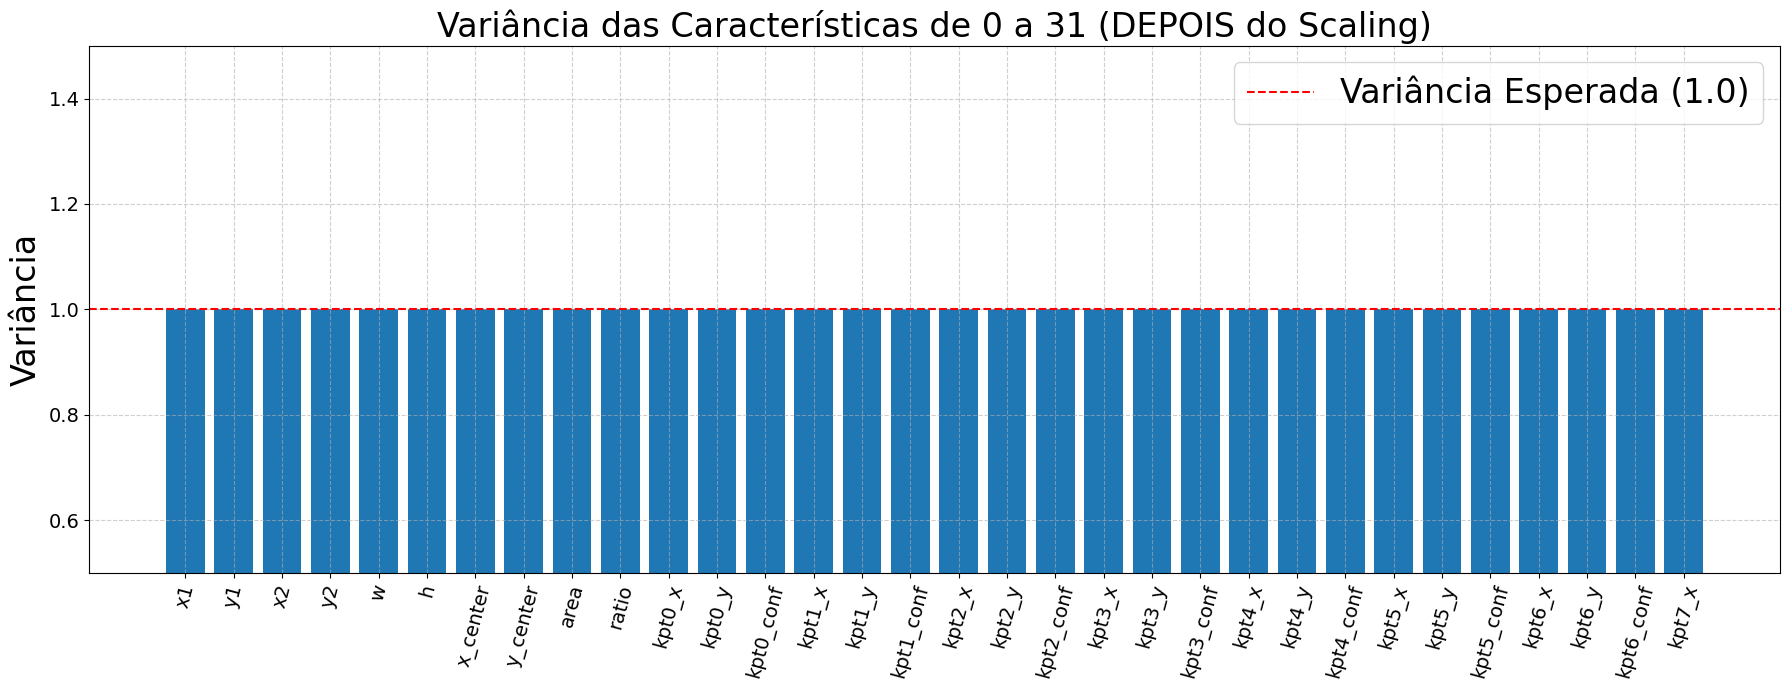

In [46]:
print("\n--- Variance after scaling ---")
# First 64 features
box_features = ["x1","y1","x2","y2","w","h","x_center","y_center","area","ratio"]
kp_features = [f"kpt{i}_{c}" for i in range(18) for c in ["x","y","conf"]]
static_features_names = box_features + kp_features
# New features (64)
velocity_features_names = [f"v_{name}" for name in static_features_names]
# All features
final_feature_names = static_features_names + velocity_features_names

plot_variance_subset(variance_after_scaling, final_feature_names, start_index=0, end_index=32)

In [24]:
# LSTM model
# Stacked LSTM technique (others: Simple LSTM, Bidirectional LSTM - offline, GRU)
lstm_model = Sequential([
    Input(shape=(WINDOW, X.shape[2])),
    LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

lstm_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(f"{OUTPUT_LSTM_MODEL_DIR}/{OUTPUT_LSTM_MODEL_BEST}", monitor='val_loss', save_best_only=True, verbose=1)

In [28]:
# LSTM Training
model_results = lstm_model.fit(
    X_train_scaled, y_train, 
    validation_data=(X_val_scaled, y_val),
    batch_size=32, 
    epochs=200, 
    callbacks=[checkpoint, early_stop],
    class_weight=class_weight_dict)

lstm_model.save(f"{OUTPUT_LSTM_MODEL_DIR}/{OUTPUT_LSTM_MODEL_FULL}")
print("Training completed successfully!")

# Salva o histórico do treinamento em um arquivo JSON
with open(f"{OUTPUT_LSTM_MODEL_DIR}/{OUTPUT_LSTM_MODEL_HISTORY}", "w") as f:
    json.dump(model_results.history, f)

Epoch 1/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6739 - loss: 0.7135
Epoch 1: val_loss improved from inf to 0.33132, saving model to results/fall_detect_yolo11n_pose_balanced/lstm_model_w30_s10_kf8_ka5_lstm/lstm_model_best.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.6742 - loss: 0.7128 - val_accuracy: 0.8762 - val_loss: 0.3313
Epoch 2/200
229/231 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8305 - loss: 0.4003
Epoch 2: val_loss did not improve from 0.33132
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8305 - loss: 0.4001 - val_accuracy: 0.8360 - val_loss: 0.3851
Epoch 3/200
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7934 - loss: 0.3892
Epoch 3: val_loss did not improve from 0.33132
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7936 - loss: 0.3890 - val_accuracy: 0.8403 - val_loss: 0.3655
Epoch 4/200
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8407 - loss: 0.3128
Epoch 4: val_loss improved from 0.33132